# Import relevant libraries

In [1]:
import pandas as pd
import numpy as np

# Import News Classification Dataset

In [2]:
df = pd.read_csv("News_classifier.csv")
df

,Title,Excerpt,Category
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics
...,...,...,...
5509,Nigeria’s Central Bank Introduces ‘Naira 4 Dol...,The Central Bank of Nigeria (CBN) has introduc...,business
5510,Super Eagles to Host Leone Stars in AFCON 2023...,Following Tuesday night’s draw for the qualifi...,sports
5511,Frustration in Nigeria Breeding Calls for Sece...,"Ekiti State Governor, Dr. Kayode Fayemi on Tue...",politics
5512,Coca-Cola European Buys Australian Bottler for...,Coca-Cola European Partners Plc has agreed to ...,business


---
# Exploratory Data Analysis (EDA)

 Rows with missing values in important columns were removed to ensure data consistency.


In [3]:
# Check shape
print("Dataset Shape:", df.shape)

Dataset Shape: (5514, 3)


In [4]:
# Check missing values
missing = df.isnull().any().sum()
missing

np.int64(1)

In [5]:
## Check column types
df.dtypes

Title       object
Excerpt     object
Category    object
dtype: object

In [6]:
col = df.columns[df.isnull().any()].tolist()
col

['Title']

In [7]:
for each in df.columns:
    print("Column: ",each) # the column name
    print(df[each].nunique()) # the number of unique values in that column
    print("~"*100) # a separator line for better readability

Column:  Title
5313
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column:  Excerpt
5313
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Column:  Category
6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5514 entries, 0 to 5513
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     5513 non-null   object
 1   Excerpt   5514 non-null   object
 2   Category  5514 non-null   object
dtypes: object(3)
memory usage: 129.4+ KB


---
# Handle Missing Values

In [10]:
# Drop rows with missing values in Title, Excerpt, or Category
df = df.dropna(subset=['Title', 'Excerpt', 'Category'])

# Verify missing values are gone
df.isnull().sum()


Title       0
Excerpt     0
Category    0
dtype: int64

---
# Combine Title + Excerpt
 The Title and Excerpt columns are merged to form a single text feature in order to capture both concise keywords and contextual information.

In [11]:
# Wrong attempt (mistake): assigned directly to a slice, which gives SettingWithCopyWarning
# df['text'] = df['Title'] + ' ' + df['Excerpt']

# Corrected code: make a copy and safely assign
df = df.copy()  # create a copy to avoid warnings
df['text'] = df['Title'].astype(str) + ' ' + df['Excerpt'].astype(str)


---

## Text Preprocessing

Text preprocessing includes:
- Lowercasing
- Removing punctuation and numbers
- Stopword removal
- Lemmatization


In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Wrong attempt (mistake): tried to clean text without function
# df['clean_text'] = df['text'].lower()

# Corrected code
df.loc[:, 'clean_text'] = df['text'].apply(preprocess_text)

df[['text', 'clean_text']].head()


,text,clean_text
0,"Uefa Opens Proceedings against Barcelona, Juve...",uefa open proceeding barcelona juventus real m...
1,Amazon Blames Inflation as It Increases Cost o...,amazon blame inflation increase cost prime eur...
2,Nigeria’s Parliament Passes Amended Electoral ...,nigeria parliament pass amended electoral bill...
3,Nigeria: Lagos Governor Tests Positive for Cov...,nigeria lagos governor test positive covid kad...
4,South Africa Calls For Calm as Electoral Refor...,south africa call calm electoral reform protes...


---
# Visualize category distribution

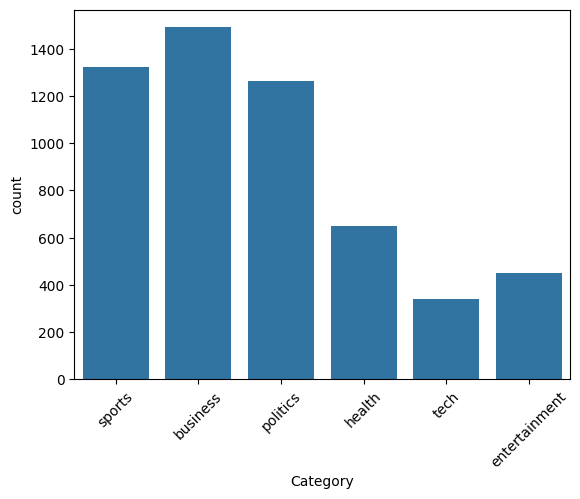

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Wrong attempt (mistake): forgot to import matplotlib, so plt.xticks would fail
sns.countplot(data=df, x='Category')
plt.xticks(rotation=45)
plt.show()



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


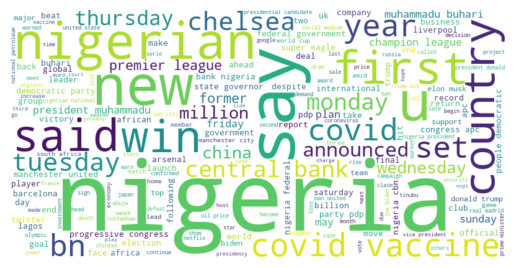

In [18]:
# Wrong attempt (mistake): tried to import WordCloud without installing the package
# from wordcloud import WordCloud
!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(' '.join(df['clean_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


--- 
# Train–Test Split

The dataset is split into training and testing sets before feature extraction 
to avoid data leakage.


In [19]:
# Wrong attempt (mistake): forgot to split before TF-IDF
# X = df['clean_text']
# y = df['Category']

# Corrected approach
X = df['clean_text']
y = df['Category']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 4410
Testing samples: 1103


---
# TF-IDF Feature Extraction

TF-IDF is applied to convert textual data into numerical feature vectors.
The vectorizer is fitted only on the training data to prevent data leakage.


In [20]:
# Wrong attempt (mistake): fitting TF-IDF on full dataset
# tfidf = TfidfVectorizer()
# tfidf.fit_transform(df['clean_text'])

# Corrected approach
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((4410, 5000), (1103, 5000))

---
# Model 1: Multinomial Naive Bayes


In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

nb_pred = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 0.8522212148685403
               precision    recall  f1-score   support

     business       0.74      0.95      0.83       298
entertainment       0.93      0.57      0.70        90
       health       0.92      0.74      0.82       129
     politics       0.87      0.96      0.91       253
       sports       0.95      0.98      0.96       265
         tech       0.82      0.13      0.23        68

     accuracy                           0.85      1103
    macro avg       0.87      0.72      0.74      1103
 weighted avg       0.86      0.85      0.83      1103



---
# Model 2: Logistic Regression


In [22]:
from sklearn.linear_model import LogisticRegression

# Wrong attempt (mistake): default max_iter caused convergence warning
# lr = LogisticRegression()

# Corrected approach
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

lr_pred = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


Logistic Regression Accuracy: 0.85766092475068
               precision    recall  f1-score   support

     business       0.76      0.90      0.83       298
entertainment       0.90      0.67      0.76        90
       health       0.92      0.78      0.85       129
     politics       0.88      0.94      0.91       253
       sports       0.96      0.97      0.97       265
         tech       0.58      0.32      0.42        68

     accuracy                           0.86      1103
    macro avg       0.83      0.76      0.79      1103
 weighted avg       0.86      0.86      0.85      1103



--- 
# Confusion Matrix

A confusion matrix is used to visualize the performance of the classification model
by showing the number of correct and incorrect predictions for each class.


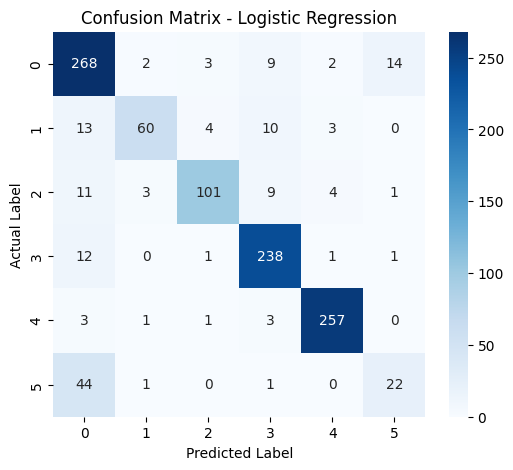

In [23]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
cm = confusion_matrix(y_test, lr_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# Model Comparison

The performance of Naive Bayes and Logistic Regression is compared using
accuracy, precision, recall, and F1-score.


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

comparison_results = {
    "Model": ["Naive Bayes", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, lr_pred)
    ],
    "Precision": [
        precision_score(y_test, nb_pred, average='weighted'),
        precision_score(y_test, lr_pred, average='weighted')
    ],
    "Recall": [
        recall_score(y_test, nb_pred, average='weighted'),
        recall_score(y_test, lr_pred, average='weighted')
    ],
    "F1-Score": [
        f1_score(y_test, nb_pred, average='weighted'),
        f1_score(y_test, lr_pred, average='weighted')
    ]
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.852221,0.862133,0.852221,0.833193
1,Logistic Regression,0.857661,0.855878,0.857661,0.850823


In [33]:
# Ask user for input
new_title = input("Enter the article Title: ")
new_excerpt = input("Enter the article Excerpt: ")

# Predict category using Logistic Regression model
predicted_category = predict_category(new_title, new_excerpt, lr, tfidf)

print("\nPredicted Category:", predicted_category)


Enter the article Title:  Nigeriaâ€™s Senate Intent on Passing Oil Reform Bill
Enter the article Excerpt:  The Nigerian Senate has fixed October 20 to commence debate on the Petroleum Industry Bill (PIB), a move the Senate



Predicted Category: politics
